In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_datareader as pdr
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
#defining tickers
tickers = ['BTC-USD', 'GC=F', 'BZ=F', '^GSPC', '^DJI', '^IXIC', 'URTH', '^FTSE', 'DX-Y.NYB', '^TNX']
tickers_dict = {
    'BTC-USD': 'Bitcoin',
    'GC=F': 'Gold',
    'BZ=F': 'Petróleo Brent',
    '^GSPC': 'S&P 500',
    '^DJI': 'Dow Jones',
    '^IXIC': 'Nasdaq',
    'URTH': 'MSCI World',
    '^FTSE': 'FTSE 100',
    'DX-Y.NYB': 'Dollar Index',
    '^TNX': 'US Treasury 10Y'
}

#download tickers data
df = yf.download(tickers, period='10y').Close

#m2 data
start = df.index.min()
end = df.index.max()
m2 = pdr.get_data_fred('M2SL', start=start, end=end)
m2.rename(columns={'M2SL': 'M2'}, inplace=True)
m2 = m2.reindex(df.index, method='ffill')

#unifying m2 data and the other assets
df['M2'] = m2['M2']

#rename columns
df.rename(columns=tickers_dict, inplace=True)
df.rename(columns={'M2': 'M2 Money Supply'}, inplace=True)
df = df.ffill().dropna()
df

[*********************100%%**********************]  10 of 10 completed


Ticker,Bitcoin,Petróleo Brent,Dollar Index,Gold,MSCI World,Dow Jones,FTSE 100,S&P 500,Nasdaq,US Treasury 10Y,M2 Money Supply
Date,,,,,,,,,,,
2014-11-01,325.748993,85.860001,86.879997,1171.099976,71.989998,17390.519531,6546.500000,2018.050049,4630.740234,2.335,11608.8
2014-11-02,325.891998,85.860001,86.879997,1171.099976,71.989998,17390.519531,6546.500000,2018.050049,4630.740234,2.335,11608.8
2014-11-03,327.553986,84.779999,87.309998,1169.400024,72.139999,17366.240234,6488.000000,2017.810059,4638.910156,2.348,11608.8
2014-11-04,330.492004,82.820000,86.980003,1167.400024,71.830002,17383.839844,6454.000000,2012.099976,4623.640137,2.342,11608.8
2014-11-05,339.485992,82.949997,87.440002,1145.400024,72.169998,17484.529297,6539.100098,2023.569946,4620.720215,2.350,11608.8
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-12,63193.023438,79.040001,102.889999,2657.600098,157.539993,42863.859375,8253.700195,5815.029785,18342.939453,4.073,21174.9
2024-10-13,62851.375000,79.040001,102.889999,2657.600098,157.539993,42863.859375,8253.700195,5815.029785,18342.939453,4.073,21174.9
2024-10-14,66046.125000,77.459999,103.300003,2647.800049,158.539993,43065.218750,8292.700195,5859.850098,18502.689453,4.098,21174.9


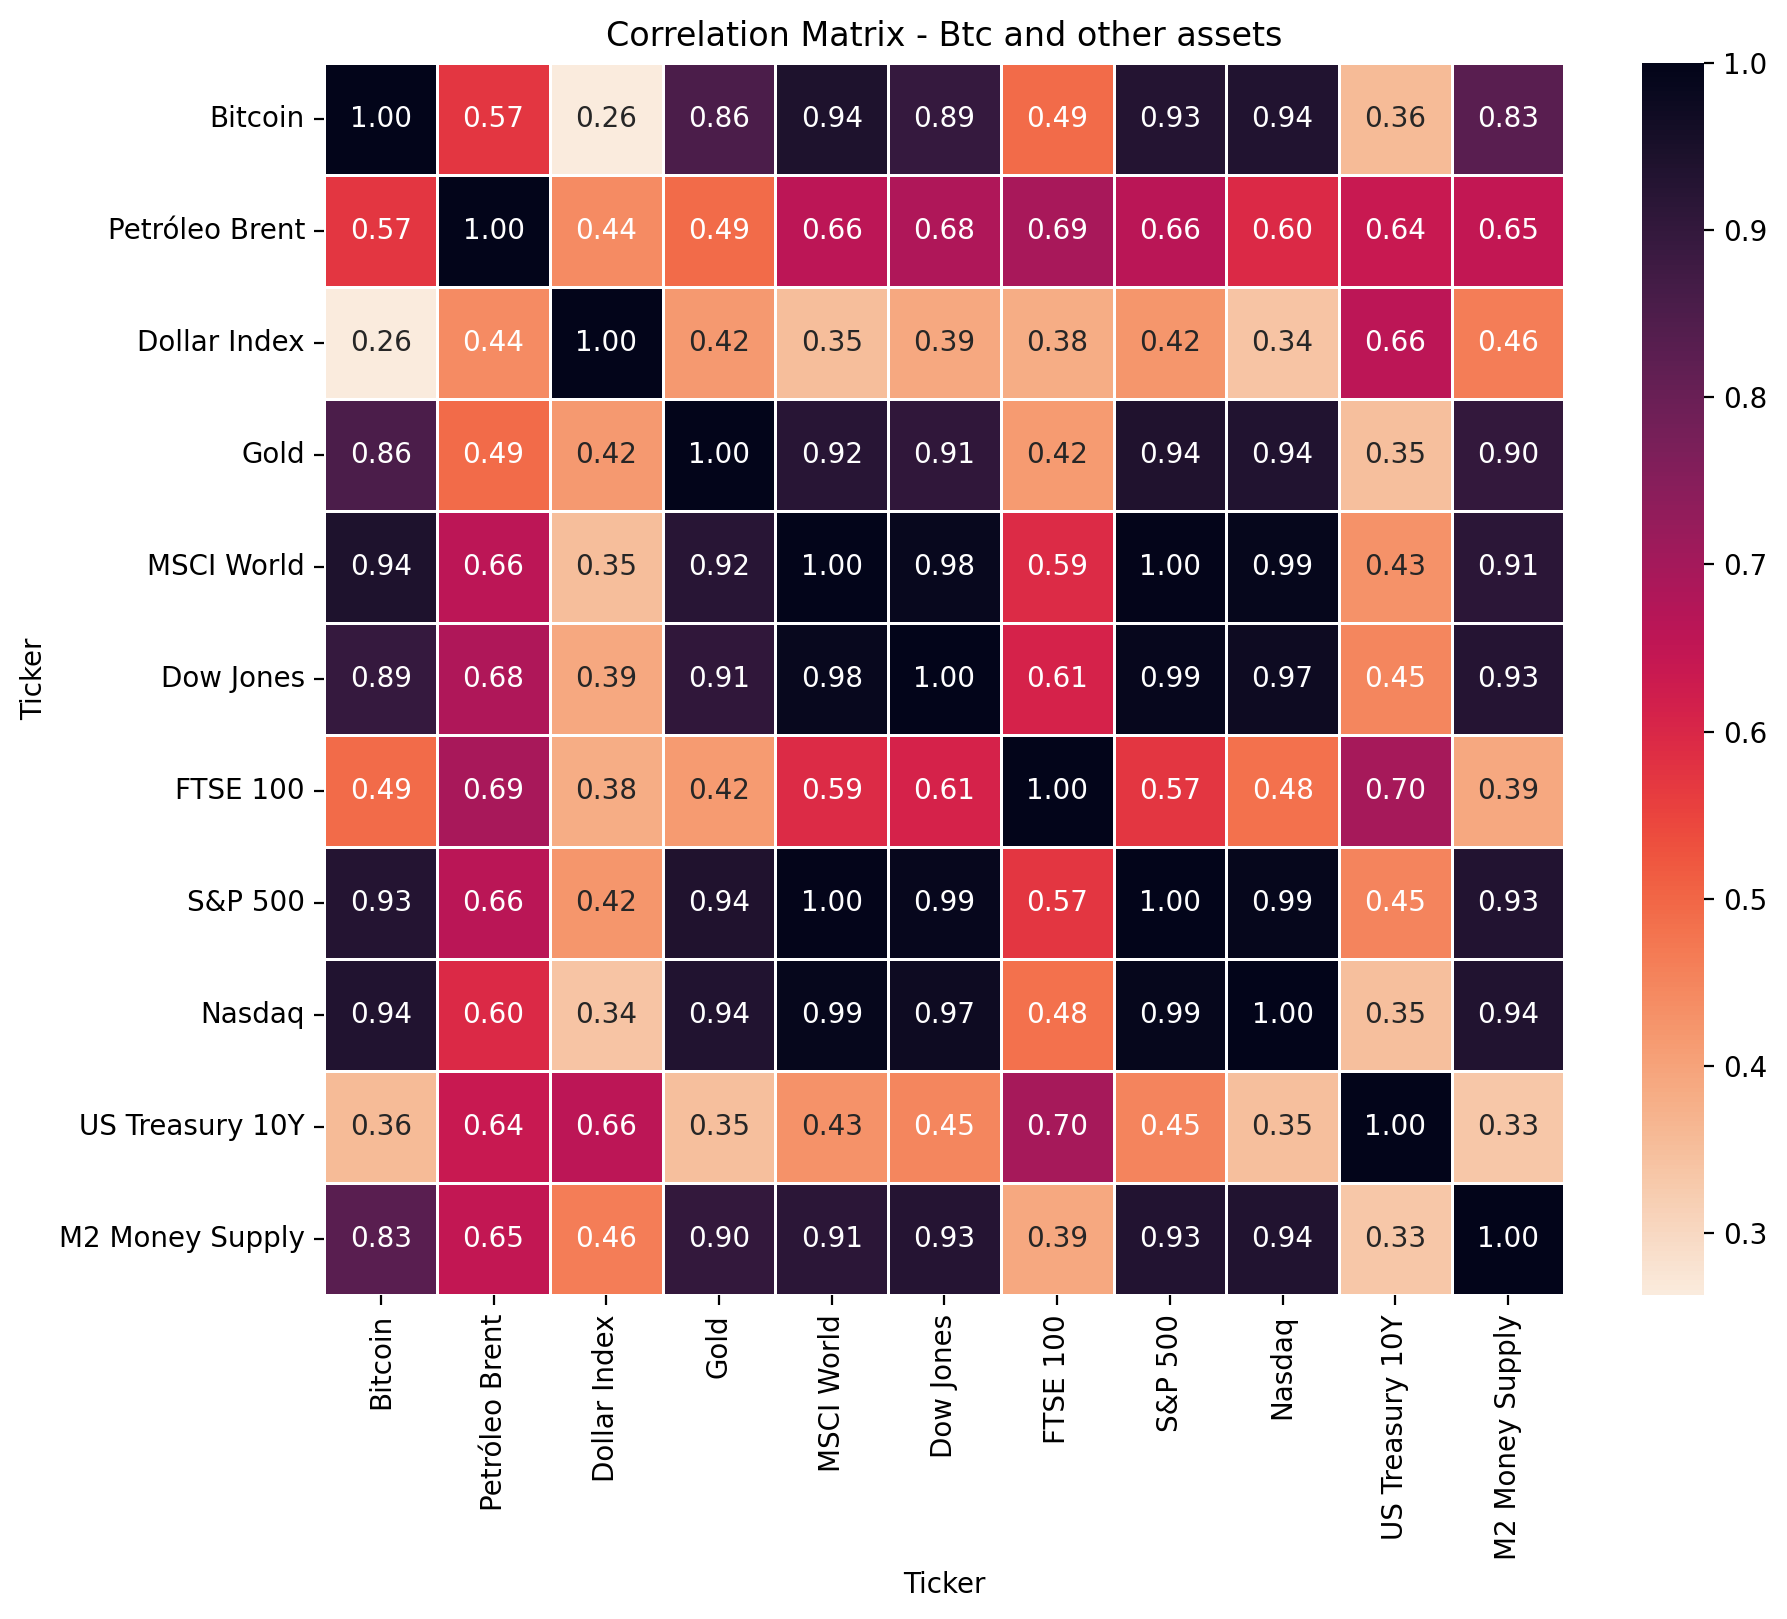

In [5]:
correlation = df.corr()
plt.figure(figsize=(10,8), dpi=200)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="rocket_r", linewidths=.5)
plt.title('Correlation Matrix - Btc and other assets')
plt.show()

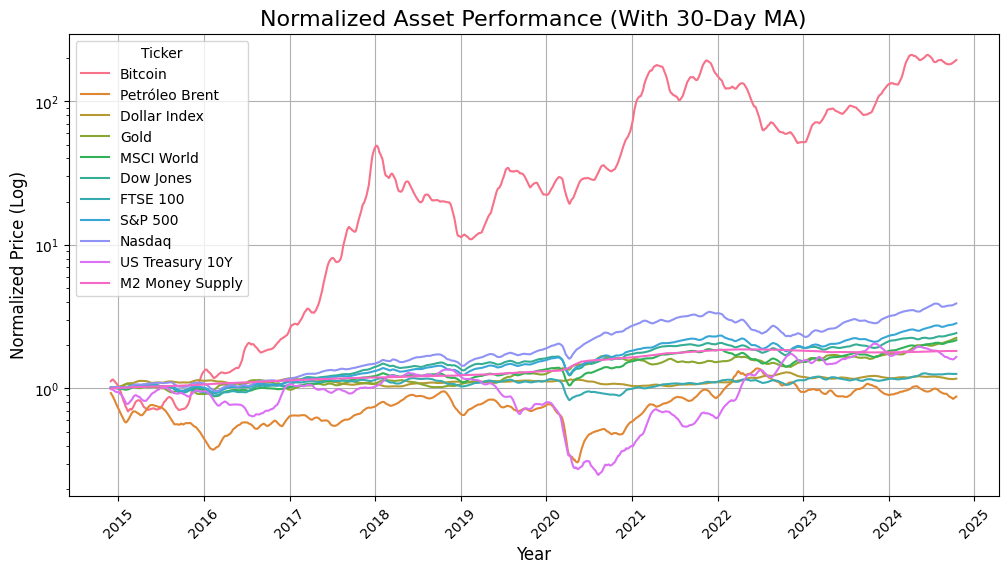

In [6]:
df_normalized = df / df.iloc[0]
df_smoothed = df_normalized.rolling(window=30).mean()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_smoothed, linestyle='-', dashes=False)
plt.yscale('log')
plt.title("Normalized Asset Performance (With 30-Day MA)", fontsize=16)
plt.ylabel('Normalized Price (Log)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, ls='solid')
plt.show()

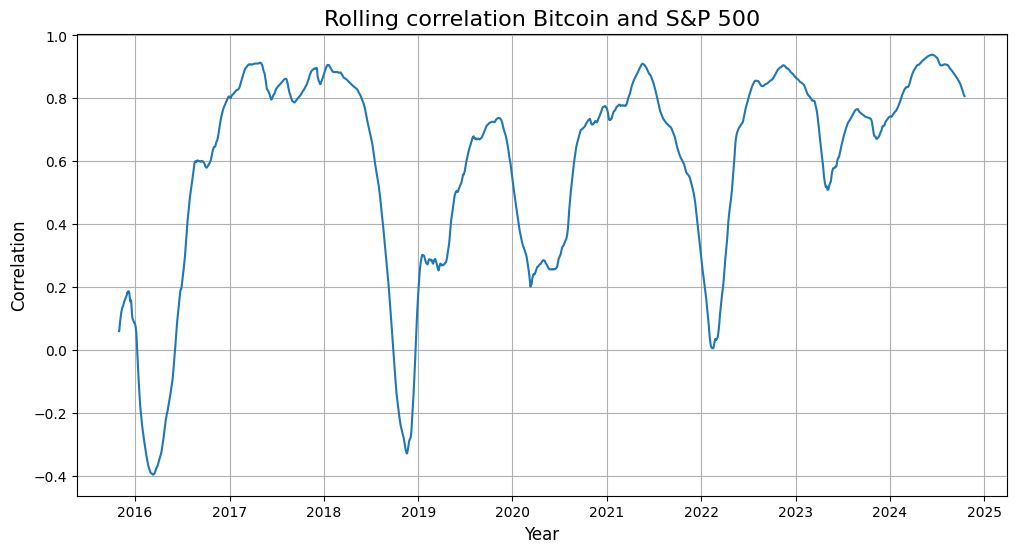

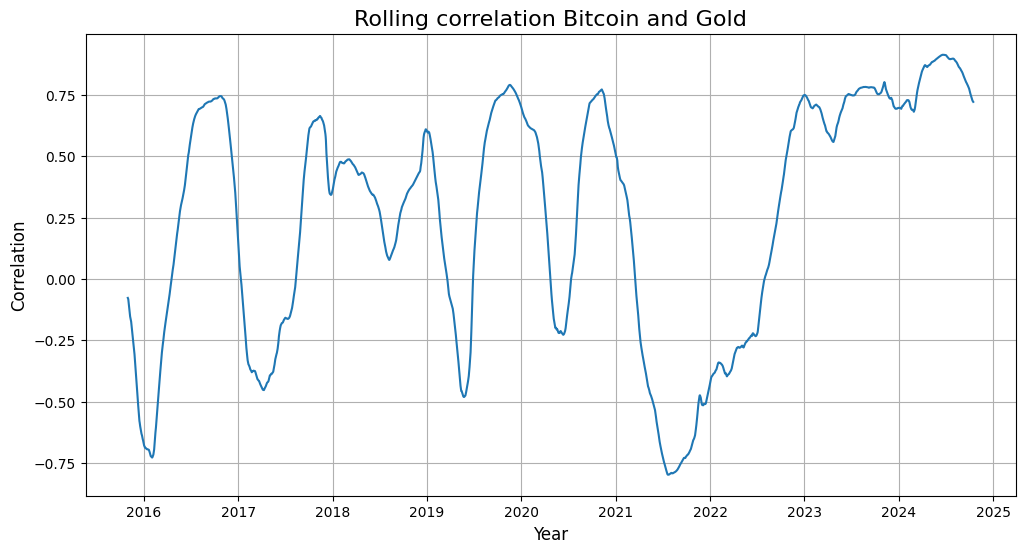

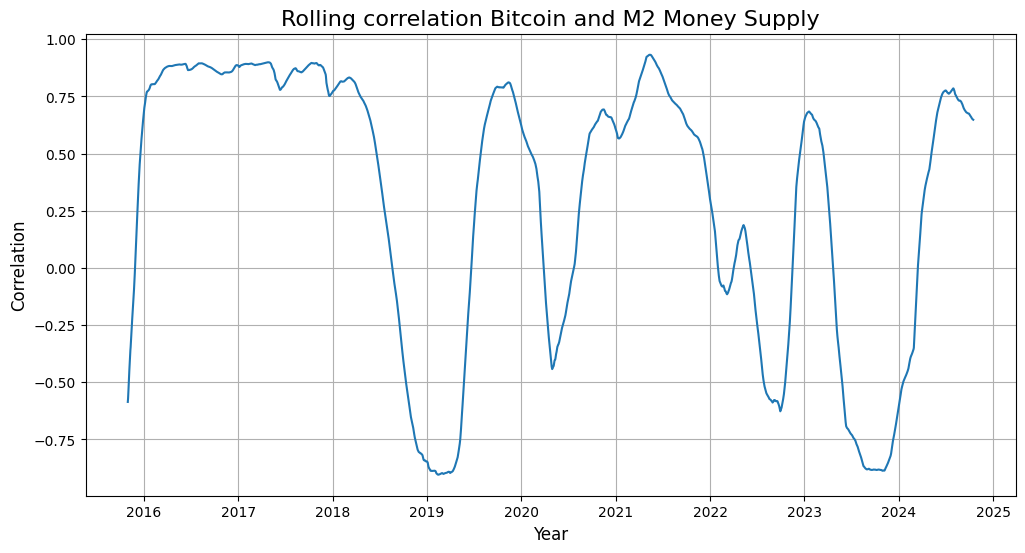

In [7]:
#rolling correlation
window = 365

def plot_rolling_correlation(asset1, asset2, window, data):
    rolling_corr = data[asset1].rolling(window).corr(data[asset2])
    plt.figure(figsize=(12,6))
    sns.lineplot(data=rolling_corr)
    plt.title(f'Rolling correlation {asset1} and {asset2}', fontsize=16)
    plt.ylabel('Correlation', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.grid(True)
    plt.show()

plot_rolling_correlation('Bitcoin', 'S&P 500', window, df)
plot_rolling_correlation('Bitcoin', 'Gold', window, df)
plot_rolling_correlation('Bitcoin', 'M2 Money Supply', window, df)

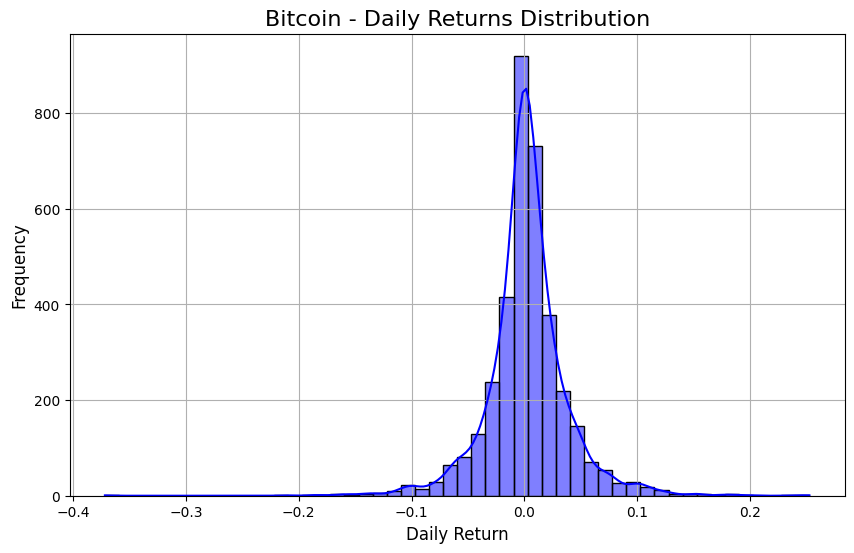

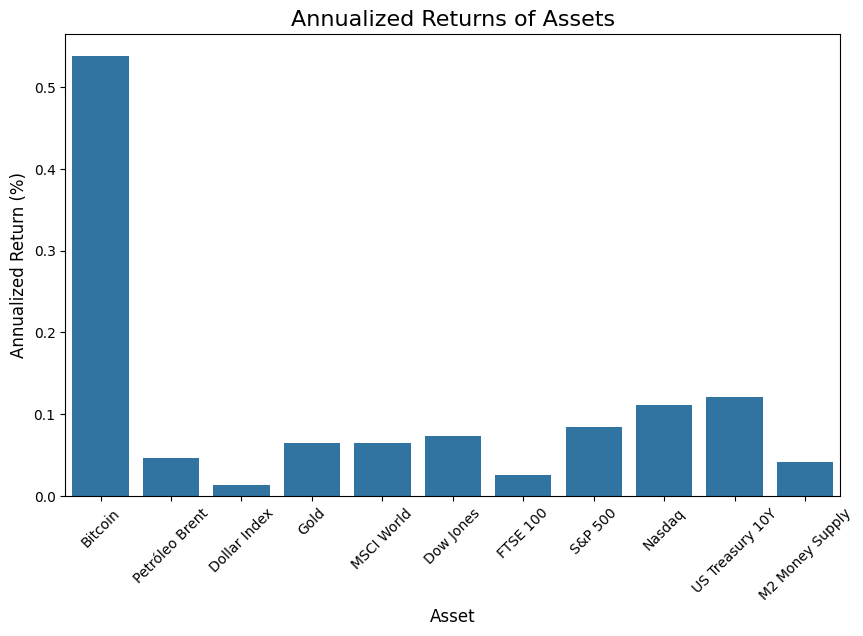

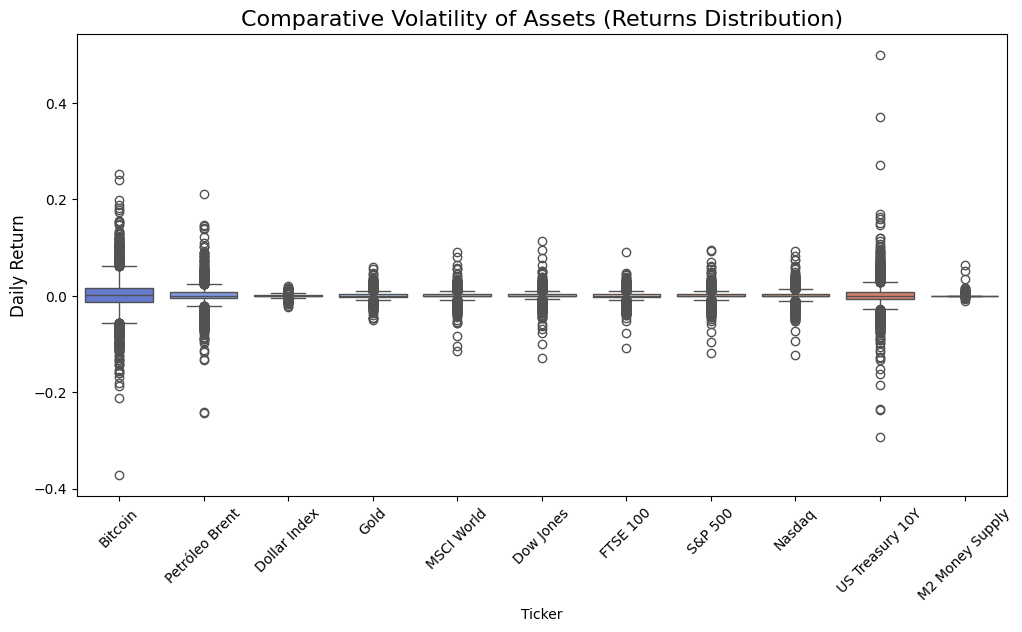

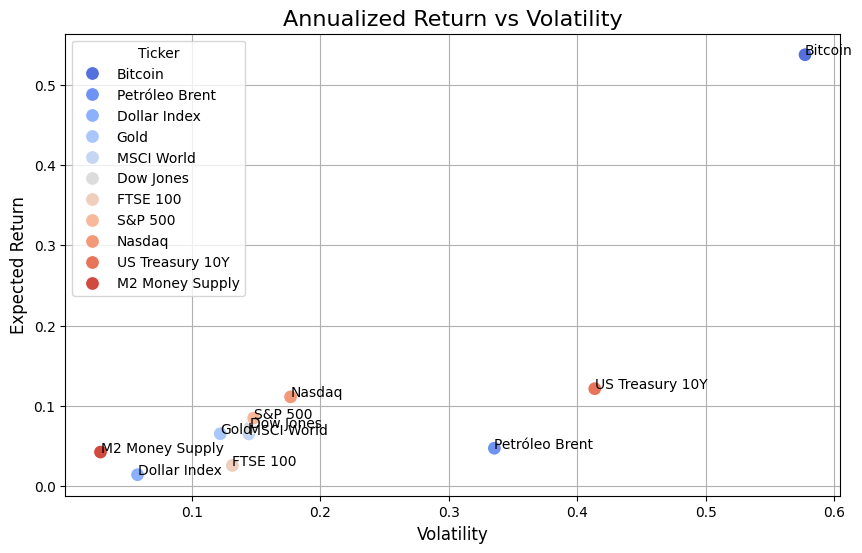

In [8]:
#daily returns distribution
returns = df.pct_change().dropna()
plt.figure(figsize=(10,6))
sns.histplot(returns['Bitcoin'], kde=True, color='blue', bins=50)
plt.title("Bitcoin - Daily Returns Distribution", fontsize=16)
plt.xlabel("Daily Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

#annualized returns and volatility
mean_returns = returns.mean() * 252
volatilities = returns.std() * np.sqrt(252)

plt.figure(figsize=(10,6))
sns.barplot(x=mean_returns.index, y=mean_returns)
plt.title('Annualized Returns of Assets', fontsize=16)
plt.ylabel('Annualized Return (%)', fontsize=12)
plt.xlabel('Asset', fontsize=12)
plt.xticks(rotation=45)
plt.show()

#volatility boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=returns, palette="coolwarm")
plt.title('Comparative Volatility of Assets (Returns Distribution)', fontsize=16)
plt.ylabel('Daily Return', fontsize=12)
plt.xticks(rotation=45)
plt.show()

#return vs volatility scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(x=volatilities, y=mean_returns, hue=mean_returns.index, palette="coolwarm", s=100)
plt.title('Annualized Return vs Volatility', fontsize=16)
plt.xlabel('Volatility', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)

for i in mean_returns.index:
    plt.text(volatilities[i], mean_returns[i], i, fontsize=10)

plt.grid(True)
plt.show()

C:\Users\Augusto\AppData\Local\Temp\ipykernel_8708\460196671.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=VaR.index, y=VaR.values, palette="coolwarm")


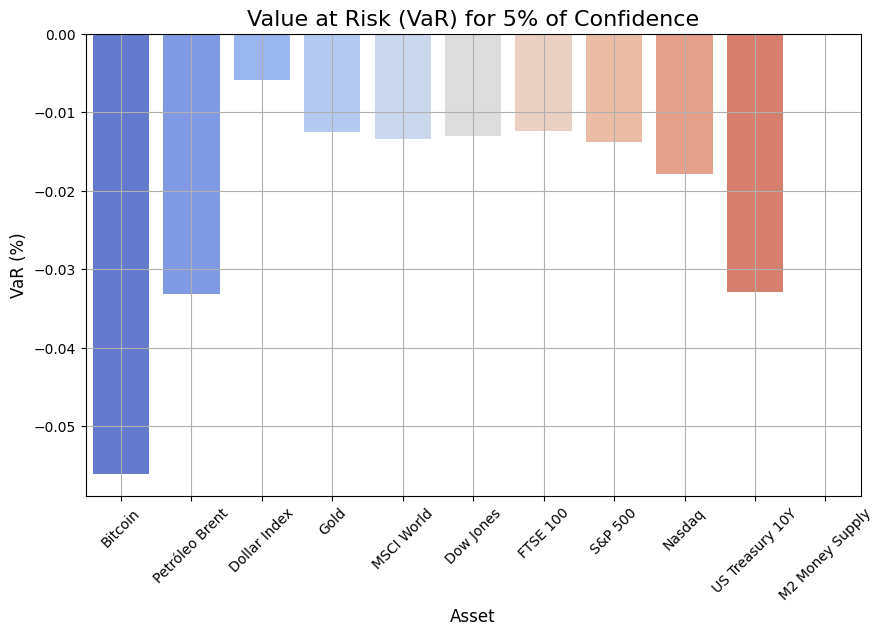

                            OLS Regression Results                            
Dep. Variable:                Bitcoin   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     6149.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:44:09   Log-Likelihood:                -37099.
No. Observations:                3638   AIC:                         7.421e+04
Df Residuals:                    3632   BIC:                         7.425e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.102e+04   1026.503    -

In [11]:
#value at risk
confidence_level = 0.05
VaR = returns.quantile(confidence_level, axis=0)
plt.figure(figsize=(10,6))
sns.barplot(x=VaR.index, y=VaR.values, palette="coolwarm")
plt.title("Value at Risk (VaR) for 5% of Confidence", fontsize=16)
plt.ylabel('VaR (%)', fontsize=12)
plt.xlabel('Asset', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#linear regression
X = df[['S&P 500', 'Gold', 'Nasdaq', 'M2 Money Supply', 'US Treasury 10Y']]
y = df['Bitcoin']
X = add_constant(X)
model = OLS(y, X).fit()
print(model.summary())

#checking multicollinearity
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Variable"] = X.columns
print(vif)

In [14]:
from statsmodels.tsa.stattools import adfuller

#check for stationarity and apply differencing if necessary
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic for {series.name}: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print(f'The series {series.name} is non-stationary\n')
        return False  # Not stationary
    else:
        print(f'The series {series.name} is stationary\n')
        return True  # Stationary

#initialize a dictionary to store the stationarity status of each column
df_columns = df.columns
is_stationary = {}
for column in df_columns:
    is_stationary[column] = check_stationarity(df[column])

#if non-stationary, apply differencing to make the data stationary
df_diff = df.copy()
for col in df_columns:
    if not is_stationary[col]:
        df_diff[col] = df_diff[col].diff()  # Apply differencing to make the series stationary
df_diff = df_diff.dropna()  # Drop rows with NaN values created by differencing

#rerun regression after differencing
X = df_diff[['S&P 500', 'Gold', 'M2 Money Supply', 'US Treasury 10Y']]
y = df_diff['Bitcoin']
X = add_constant(X)
model = OLS(y, X).fit()

print(model.summary())

#check for autocorrelation in the residuals
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson Statistic: {dw_stat}')

ADF Statistic for Bitcoin: -0.6856641208667372
p-value: 0.8504279910255372
The series Bitcoin is non-stationary

ADF Statistic for Petróleo Brent: -2.105119295754792
p-value: 0.24246109590550252
The series Petróleo Brent is non-stationary

ADF Statistic for Dollar Index: -2.4175716979910717
p-value: 0.13683822014975688
The series Dollar Index is non-stationary

ADF Statistic for Gold: 1.5663664694534074
p-value: 0.9977530808768627
The series Gold is non-stationary

ADF Statistic for MSCI World: 0.013074265056277975
p-value: 0.959600055376173
The series MSCI World is non-stationary

ADF Statistic for Dow Jones: -0.17348872648122837
p-value: 0.9416087931811735
The series Dow Jones is non-stationary

ADF Statistic for FTSE 100: -2.320493975494644
p-value: 0.16544341866361767
The series FTSE 100 is non-stationary

ADF Statistic for S&P 500: 0.5547327000140446
p-value: 0.9864450624985581
The series S&P 500 is non-stationary

ADF Statistic for Nasdaq: 0.3339727291744646
p-value: 0.9788505592

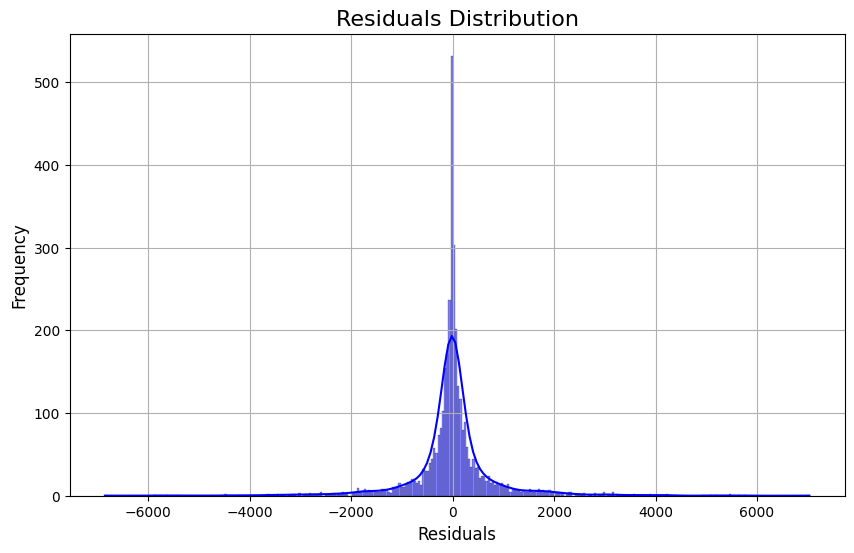

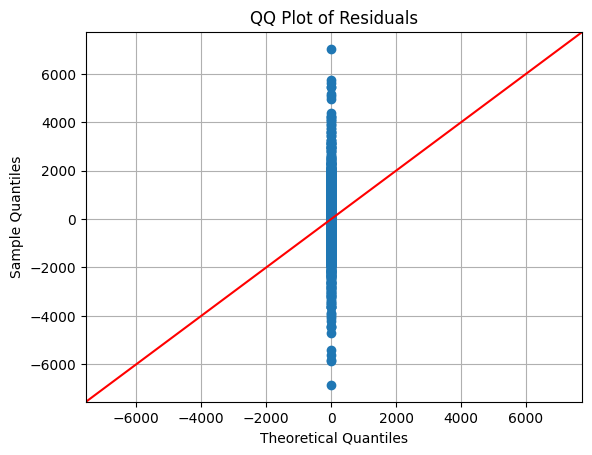

In [15]:
residuals = model.resid

#histogram of residuops
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

#qq plot to check if residuals follow a normal distribution
sm.qqplot(residuals, line ='45')
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

c:\Users\Augusto\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.015e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Bitcoin   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -25008.3
Distribution:                  Normal   AIC:                           50024.7
Method:            Maximum Likelihood   BIC:                           50049.5
                                        No. Observations:                 3637
Date:                Wed, Oct 16 2024   Df Residuals:                     3636
Time:                        13:46:23   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3361      0.299      1.123      0.261 [ -0.250,  0.92

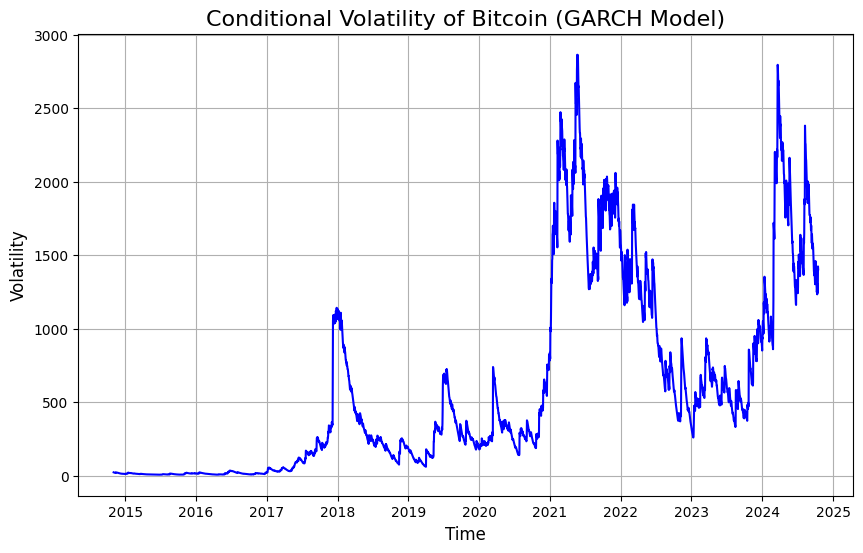

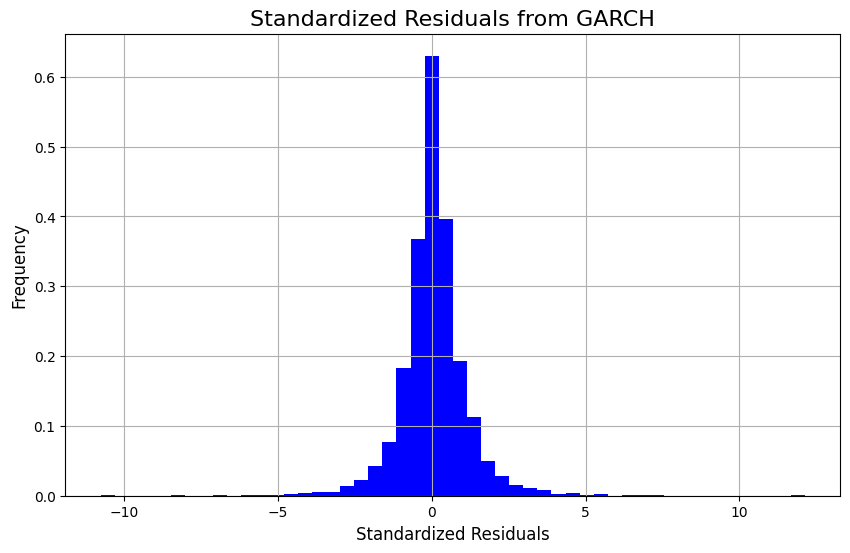

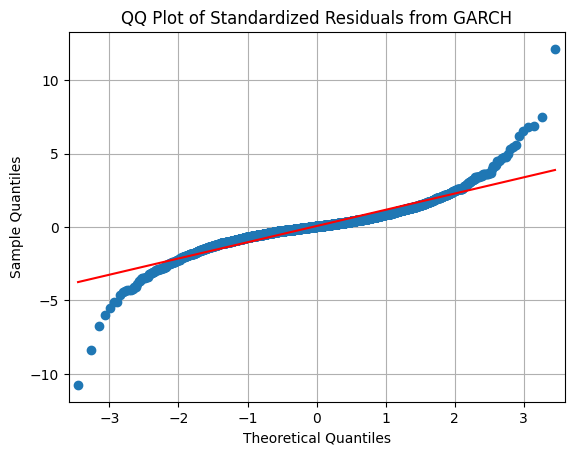

In [16]:
from arch import arch_model

returns_bitcoin = df_diff['Bitcoin'].dropna()

#fit a GARCH model
garch_model = arch_model(returns_bitcoin, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

print(garch_fit.summary())

#plot the conditional volatility (volatility over time)
plt.figure(figsize=(10,6))
plt.plot(garch_fit.conditional_volatility, color='blue')
plt.title('Conditional Volatility of Bitcoin (GARCH Model)', fontsize=16)
plt.ylabel('Volatility', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.grid(True)
plt.show()

#plot standardized residuals to check normality
standardized_residuals = garch_fit.resid / garch_fit.conditional_volatility
plt.figure(figsize=(10,6))
plt.hist(standardized_residuals, bins=50, color='blue', density=True)
plt.title('Standardized Residuals from GARCH', fontsize=16)
plt.xlabel('Standardized Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

#plot the QQ plot for the residuals to check normality
from statsmodels.graphics.gofplots import qqplot
qqplot(standardized_residuals, line='s')
plt.title('QQ Plot of Standardized Residuals from GARCH')
plt.grid(True)
plt.show()

In [17]:
garch_model = arch_model(returns_bitcoin, vol='Garch', p=1, q=1, dist='StudentsT')
garch_fit = garch_model.fit(disp="off")
print(garch_fit.summary())


c:\Users\Augusto\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.015e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      Bitcoin   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -24383.5
Distribution:      Standardized Student's t   AIC:                           48777.0
Method:                  Maximum Likelihood   BIC:                           48808.0
                                              No. Observations:                 3637
Date:                      Wed, Oct 16 2024   Df Residuals:                     3636
Time:                              13:46:37   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0